In [6]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

In [7]:
# Step 2: Load the Cleaned Dataset
data_path = "../data/worldbank_gdp_cleaned.csv"

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}. Please run the EDA notebook first.")

# Load the dataset
df = pd.read_csv(data_path)

In [8]:
# Step 3: Function to Train, Forecast and Evaluate LSTM

def train_lstm(country_name, forecast_years=5, split_year=2015):
    """
    Train an LSTM model for a given country and forecast future GDP growth rate.

    Args:
    country_name (str): Name of the country.
    forecast_years (int): Number of years to forecast.
    split_year (int): Year to split data into train and test.

    Returns:
    - forecast (np.array): Forecasted values
    - full_series (np.array): Full series including forecast
    - full_years (list): List of years
    - rmse: RMSE score
    - mae: MAE score
    """
    country_df = df[df['country'] == country_name].sort_values('Year')
    if country_df.empty:
        raise ValueError(f"No data found for country: {country_name}")

    # Select the target variable
    y = country_df['GDP Growth Rate (%)'].values.reshape(-1, 1)
    years = country_df['Year'].tolist()

    # Scale the data
    scaler = MinMaxScaler()
    y_scaled = scaler.fit_transform(y)

    # Train-Test split
    split_idx = years.index(split_year)
    y_train, y_test = y_scaled[:split_idx+1], y_scaled[split_idx+1:]

    # Create sequences
    def create_sequences(data, seq_length=3):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    seq_length = 3
    X_train, y_train_seq = create_sequences(y_train, seq_length)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train model
    model.fit(X_train, y_train_seq, epochs=100, verbose=0)

    # Forecast future
    last_seq = y_train[-seq_length:]
    forecast_scaled = []

    for _ in range(len(y_test)):
        pred = model.predict(last_seq.reshape(1, seq_length, 1), verbose=0)
        forecast_scaled.append(pred.flatten()[0])
        last_seq = np.append(last_seq[1:], pred, axis=0)

    # Inverse scaling
    forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
    y_test_actual = scaler.inverse_transform(y_test).flatten()

    # Full series
    full_series = np.concatenate([scaler.inverse_transform(y_train).flatten(), forecast])
    full_years = years

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test_actual, forecast))
    mae = mean_absolute_error(y_test_actual, forecast)

    return forecast, full_series, full_years, rmse, mae

/Users/deepakdeokar/Desktop/GDP_Forecasting_Project/venv4/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


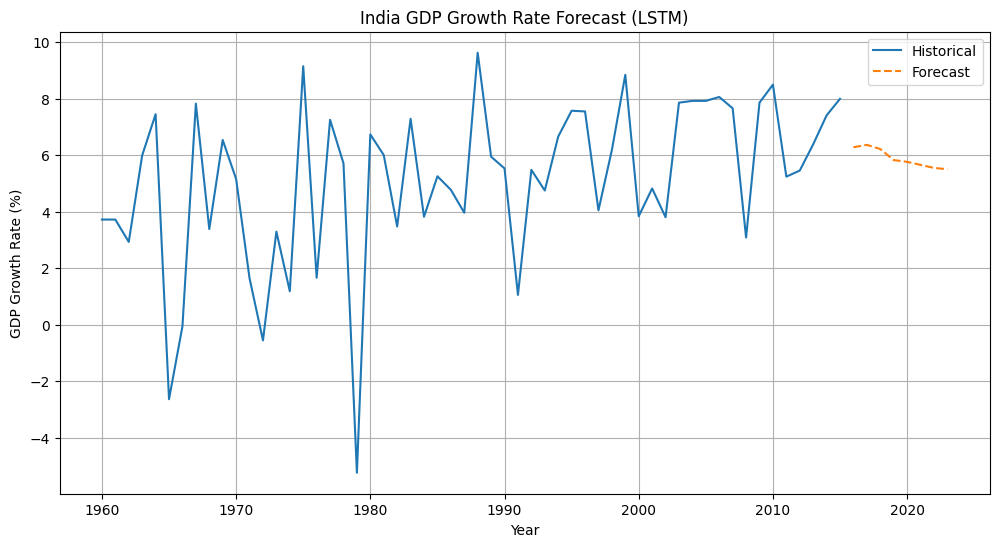


Evaluation for India:
RMSE: 4.56
MAE: 3.03


In [9]:
# Step 4: Forecast and Evaluate Example Country
example_country = "India"
forecast, full_series, full_years, rmse, mae = train_lstm(example_country, forecast_years=8, split_year=2015)

# Step 5: Plot the Result
plt.figure(figsize=(12,6))
plt.plot(full_years[:-len(forecast)], full_series[:-len(forecast)], label="Historical")
plt.plot(full_years[-len(forecast):], full_series[-len(forecast):], label="Forecast", linestyle='--')
plt.title(f"{example_country} GDP Growth Rate Forecast (LSTM)")
plt.xlabel("Year")
plt.ylabel("GDP Growth Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Print Evaluation Metrics
print(f"\nEvaluation for {example_country}:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

In [10]:
# Save evaluation metrics to file
import csv

results_path = "../data/model_results.csv"

# If file doesn't exist, create it and write header
if not os.path.exists(results_path):
    with open(results_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Model", "Country", "RMSE", "MAE"])  # header

# Append results
with open(results_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["LSTM", example_country, rmse, mae])